## 1) 
#### use gradient tape to find the derivtive of the function f(x) = sin(x) for x = [0,0.1,0.2,0.3]

In [1]:
# Nicholas Garde
# 227006946

import tensorflow as tf

input_var = tf.Variable([0,0.1,0.2,0.3])
with tf.GradientTape() as tape:
   result = tf.sin(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor([1.        0.9950042 0.9800666 0.9553365], shape=(4,), dtype=float32)


## 2)
#### "Classifying movie reviews: A binary classification example" tune, display results on train,vali,test

In [2]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import copy

D = {
    'layers': [3,5,7],
    'neurons': [8,16,32,64],
    'activation': ['relu','tanh','sigmoid'],
    'epochs': [20,30,50],
    'loss': ['binary_crossentropy','hinge'],
    'learning_rate': [0.01,0.001,0.0001]
}

# Track top 3 models
best_models = []

def update_best_models(model, history, learning_rate, lyers, neurons, activation, epochs, loss):
    global best_models
    val_acc = max(history['val_accuracy'])  # Get best validation accuracy
    print(f"Model accuracy: {val_acc}",end='')
    
    # Store model details
    model_entry = {
        'val_acc': val_acc,
        'model_config': model.to_json(),
        'model_weights': copy.deepcopy(model.get_weights()),
        'layers': lyers,
        'neurons': neurons,
        'activation': activation,
        'epochs': epochs,
        'loss': loss,
        'learning_rate': learning_rate
    }
    
    # Maintain top 3 models
    best_models.append(model_entry)
    best_models = sorted(best_models, key=lambda x: x['val_acc'], reverse=True)[:3]
    if best_models[0]['val_acc'] == val_acc: print(" New best model found!")
    elif best_models[1]['val_acc'] == val_acc: print(" New #2 model found!")
    elif best_models[2]['val_acc'] == val_acc: print(" New #3 model found!")
    else: print('')

for lyers in D['layers']:
    for neurons in D['neurons']:
        for activation in D['activation']:
            for epochs in D['epochs']:
                for loss in D['loss']:
                    for learning_rate in D['learning_rate']:
                        print(f"Training model with {learning_rate} lr, {lyers} layers, {neurons} neurons, {activation} activation, {epochs} epochs, {loss} loss")
                        model_layers = [layers.Dense(neurons, activation=activation)]
                        for _ in range(lyers - 2):
                            model_layers.append(layers.Dense(neurons, activation=activation))
                        model_layers.append(layers.Dense(1, activation="sigmoid"))
                        model = keras.Sequential(model_layers)
                        
                        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                                    loss=loss,
                                    metrics=['accuracy'])
                        
                        history = model.fit(partial_x_train,
                                            partial_y_train,
                                            epochs=epochs,
                                            batch_size=512,
                                            validation_data=(x_val, y_val),
                                            verbose=0).history
                        
                        update_best_models(model, history, learning_rate, lyers, neurons, activation, epochs, loss)
                    
# Compare the top 3 models on the test set
for i, model_entry in enumerate(best_models):
    print(f'{model_entry["val_acc"]:.4f} {model_entry["learning_rate"]}lr {model_entry["layers"]}l {model_entry["neurons"]}n {model_entry["activation"]} {model_entry["epochs"]}ep {model_entry["loss"]}')
    restored_model = keras.models.model_from_json(model_entry['model_config'])
    restored_model.set_weights(model_entry['model_weights'])
    restored_model.compile(optimizer=keras.optimizers.Adam(learning_rate=model_entry['learning_rate']), loss=model_entry['loss'], metrics=['accuracy'])
    test_loss, test_acc = restored_model.evaluate(x_test, y_test)
    print(f"Model {i+1}: Test Accuracy = {test_acc:.4f}, Validation Accuracy = {model_entry['val_acc']:.4f}")


Training model with 0.01 lr, 3 layers, 8 neurons, relu activation, 20 epochs, binary_crossentropy loss
Model accuracy: 0.8830000162124634 New best model found!
Training model with 0.001 lr, 3 layers, 8 neurons, relu activation, 20 epochs, binary_crossentropy loss
Model accuracy: 0.8891000151634216 New best model found!
Training model with 0.0001 lr, 3 layers, 8 neurons, relu activation, 20 epochs, binary_crossentropy loss
Model accuracy: 0.8823999762535095 New #3 model found!
Training model with 0.01 lr, 3 layers, 8 neurons, relu activation, 20 epochs, hinge loss
Model accuracy: 0.8845000267028809 New #2 model found!
Training model with 0.001 lr, 3 layers, 8 neurons, relu activation, 20 epochs, hinge loss
Model accuracy: 0.8885999917984009 New #2 model found!
Training model with 0.0001 lr, 3 layers, 8 neurons, relu activation, 20 epochs, hinge loss
Model accuracy: 0.8748000264167786
Training model with 0.01 lr, 3 layers, 8 neurons, relu activation, 30 epochs, binary_crossentropy loss
M

In [7]:
learning_rate = best_models[2]['learning_rate']
lyers = best_models[2]['layers']
neurons = best_models[2]['neurons']
activation = best_models[2]['activation']
epochs = best_models[2]['epochs']
loss = best_models[2]['loss']

print(f"Training model with {learning_rate} lr, {lyers} layers, {neurons} neurons, {activation} activation, {epochs} epochs, {loss} loss")
model_layers = [layers.Dense(neurons, activation=activation)]
for _ in range(lyers - 2):
    model_layers.append(layers.Dense(neurons, activation=activation))
model_layers.append(layers.Dense(1, activation="sigmoid"))
model = keras.Sequential(model_layers)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=loss,
            metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1).history
print(f"Model accuracy: {max(history['val_accuracy'])}")


Training model with 0.0001 lr, 5 layers, 32 neurons, sigmoid activation, 50 epochs, binary_crossentropy loss


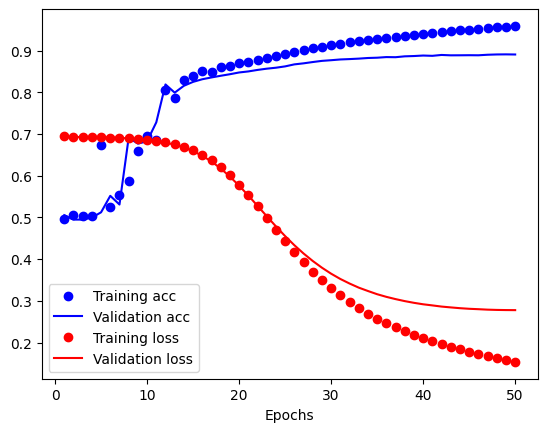

In [9]:
import matplotlib.pyplot as plt

loss_values = history["loss"]
val_loss_values = history["val_loss"]
epochs = range(1, len(loss_values) + 1)
acc = history["accuracy"]
val_acc = history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.plot(epochs, loss_values, "ro", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [10]:
for model in best_models:
    print(f'{model["val_acc"]:.4f} {model["learning_rate"]}lr {model["layers"]}l {model["neurons"]}n {model["activation"]} {model["epochs"]}ep {model["loss"]}')
    restored_model = keras.models.model_from_json(model['model_config'])
    restored_model.set_weights(model['model_weights'])
    restored_model.compile(optimizer=keras.optimizers.Adam(learning_rate=model['learning_rate']), loss=model['loss'], metrics=['accuracy'])
    test_loss, test_acc = restored_model.evaluate(x_test, y_test)
    print(f"Test Accuracy = {test_acc:.4f}, Validation Accuracy = {model['val_acc']:.4f}")

0.8934 0.01lr 3l 16n sigmoid 50ep binary_crossentropy
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.8551 - loss: 0.8666
Test Accuracy = 0.8556, Validation Accuracy = 0.8934
0.8931 0.001lr 3l 8n sigmoid 20ep binary_crossentropy
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.8808 - loss: 0.3390
Test Accuracy = 0.8828, Validation Accuracy = 0.8931
0.8930 0.0001lr 5l 32n sigmoid 50ep binary_crossentropy
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.8819 - loss: 0.2946
Test Accuracy = 0.8840, Validation Accuracy = 0.8930
